# Lab 3 - Detección de Objetos con YOLOv11

### Objetivos

1. Cargar un dataset en formato YOLO e inspeccionar su estructura (imágenes y etiquetas).
2. Visualizar ejemplos anotados para entender el formato y la calidad de anotación.
3. Entrenar un detector YOLOv11 desde Ultralytics sobre el dataset.
4. Evaluar resultados básicos y realizar inferencia sobre imágenes.
5. Probar inferencia en tiempo real con cámara web.


## 1) Setup e instalación de dependencias


In [ ]:
!pip -q install --upgrade ultralytics opencv-python-headless seaborn
import warnings, os, sys, math, glob, time, random, json, yaml, textwrap
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from google.colab import files
from google.colab.output import eval_js
from IPython.display import display, Javascript
from base64 import b64decode, b64encode
import io

import cv2
from ultralytics import YOLO

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available(), "| Device:", device)
print("Ultralytics:", __import__('ultralytics').__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch: 2.8.0+cu126 | CUDA: True | Device: cuda
Ultralytics: 8.3.205


## 2) Descarga del dataset

Para este lab ocuparemos el dataset [Construction Site Safety Image Dataset Roboflow](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/) de Kaggle.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehilsanyal/construction-site-safety-image-dataset-roboflow")

print("Path to dataset files:", path)

100%|██████████| 206M/206M [00:10<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/versions/3


## 3) Dataset: estructura, formato YOLO y YAML

**Formato YOLO de detección (por imagen):**
- Archivo de etiqueta `.txt` con **N** líneas (una por objeto).
- Cada línea: `class_id x_center y_center width height` (valores normalizados 0–1).
- Directorios típicos:
  - `train/images/`, `train/labels/`
  - `valid/images/`, `valid/labels/`
  - `test/images/`,  `test/labels/`


In [ ]:
# Raíz del dataset con subcarpetas train/valid/test en formato YOLO
DATASET_ROOT = Path(f'{path}/css-data')

# Lista de clases (en el orden de los IDs de anotación)
CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

# Crear data.yaml para Ultralytics
data_dict = {
    'train': str(DATASET_ROOT / 'train'),
    'val':   str(DATASET_ROOT / 'valid'),
    'test':  str(DATASET_ROOT / 'test'),
    'nc': len(CLASSES),
    'names': CLASSES
}

WORK_DIR = Path('/content/working')
WORK_DIR.mkdir(parents=True, exist_ok=True)
DATA_YAML_PATH = WORK_DIR / 'data.yaml'
with open(DATA_YAML_PATH, 'w') as f:
    yaml.safe_dump(data_dict, f, sort_keys=False, allow_unicode=True)

print('data.yaml generado en:', DATA_YAML_PATH)
print('Contenido YAML:\n', yaml.safe_dump(data_dict, sort_keys=False, allow_unicode=True))


data.yaml generado en: /content/working/data.yaml
Contenido YAML:
 train: /root/.cache/kagglehub/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/versions/3/css-data/train
val: /root/.cache/kagglehub/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/versions/3/css-data/valid
test: /root/.cache/kagglehub/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/versions/3/css-data/test
nc: 10
names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle



## 4) Exploración rápida: tamaños y balance de clases

Revisamos distribución de clases. Esto ayuda a detectar desbalances o errores en la estructura.


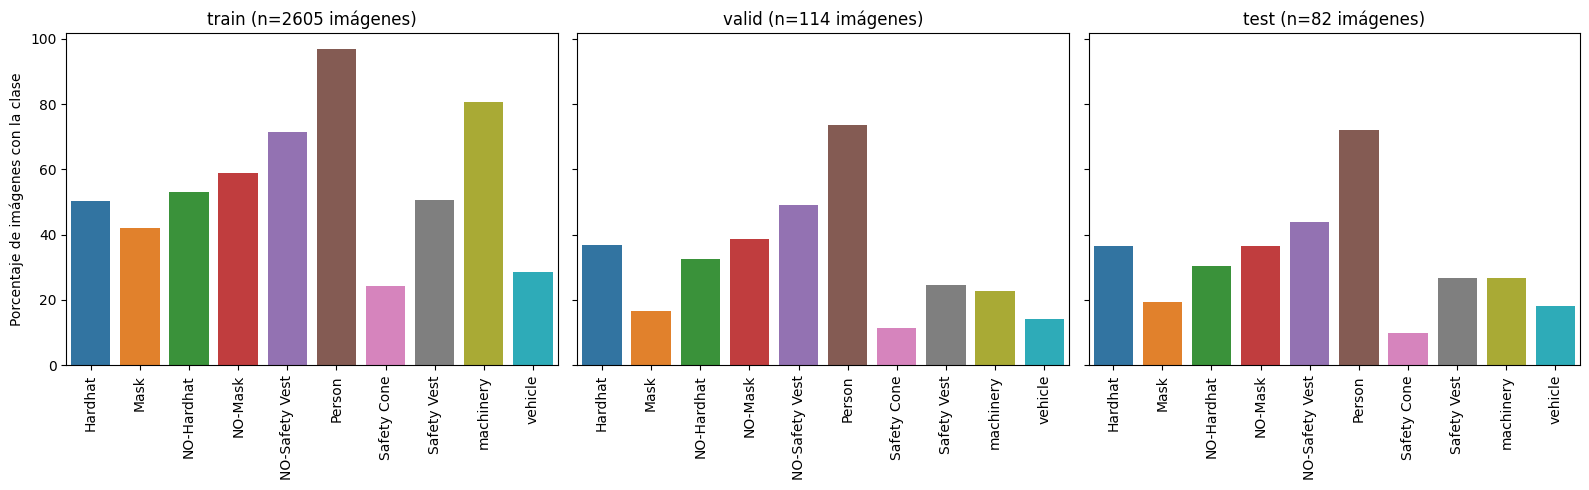

In [ ]:
num_classes = len(CLASSES)
INPUT_DIR = str(DATASET_ROOT)

# Mapea id de clase (str) -> nombre de clase
class_idx = {str(i): CLASSES[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:
    class_count = {CLASSES[i]: 0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')
    if not os.path.exists(path):
        print(f"No existe {path}. Saltando...")
        data_len[mode] = 0
        class_stat[mode] = class_count
        continue

    label_files = [f for f in os.listdir(path) if f.endswith('.txt')]
    for file in label_files:
        with open(os.path.join(path, file), 'r') as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
            # IDs de clase únicos por imagen (soporta IDs con >1 dígito)
            file_class_ids = set(ln.split()[0] for ln in lines if len(ln.split()) >= 5)
            for cid in file_class_ids:
                if cid in class_idx:
                    class_count[class_idx[cid]] += 1

    data_len[mode] = len(label_files)
    class_stat[mode] = class_count

# Gráfico: porcentaje de imágenes que contienen cada clase
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
for i, mode in enumerate(['train', 'valid', 'test']):
    denom = max(1, data_len.get(mode, 0))  # evita división por cero
    df_mode = pd.DataFrame({mode: class_stat[mode]}).T / denom * 100.0
    sns.barplot(data=df_mode, ax=ax[i])
    ax[i].set_title(f"{mode} (n={denom} imágenes)")
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_ylabel('Porcentaje de imágenes con la clase')
plt.tight_layout()
plt.show()

## 5) Visualización: ejemplos con boxes (labels YOLO)

Dibujamos las bounding boxes a partir de los `.txt`. Útil para auditar anotaciones.


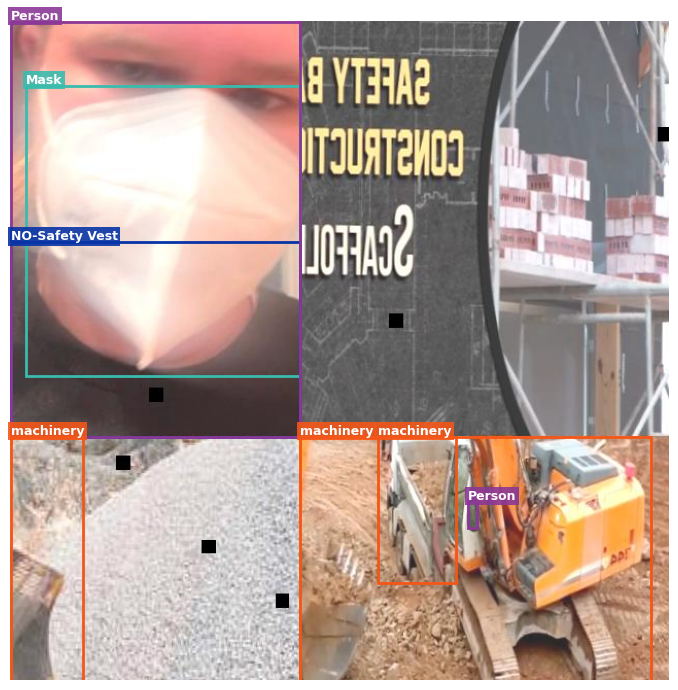

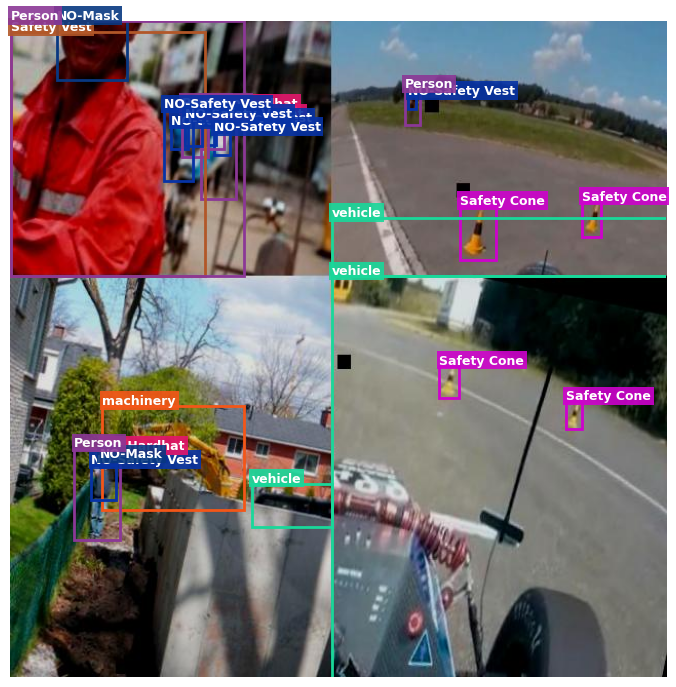

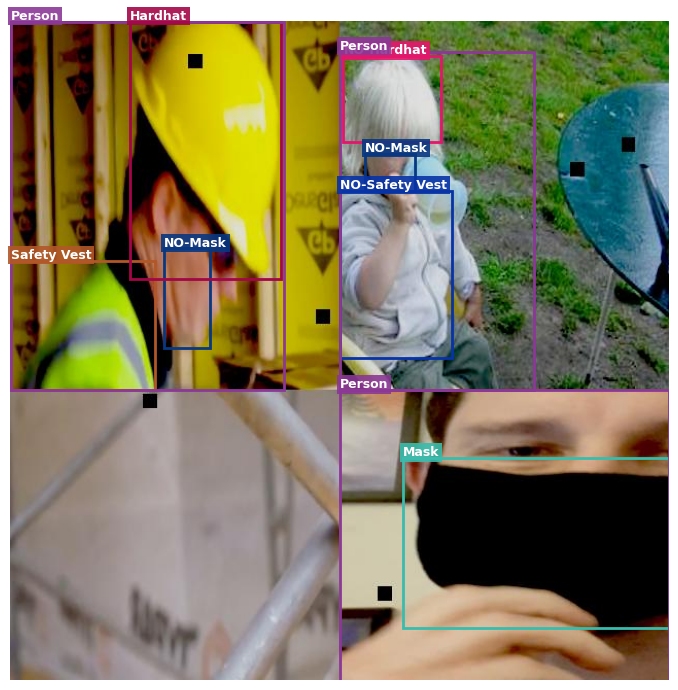

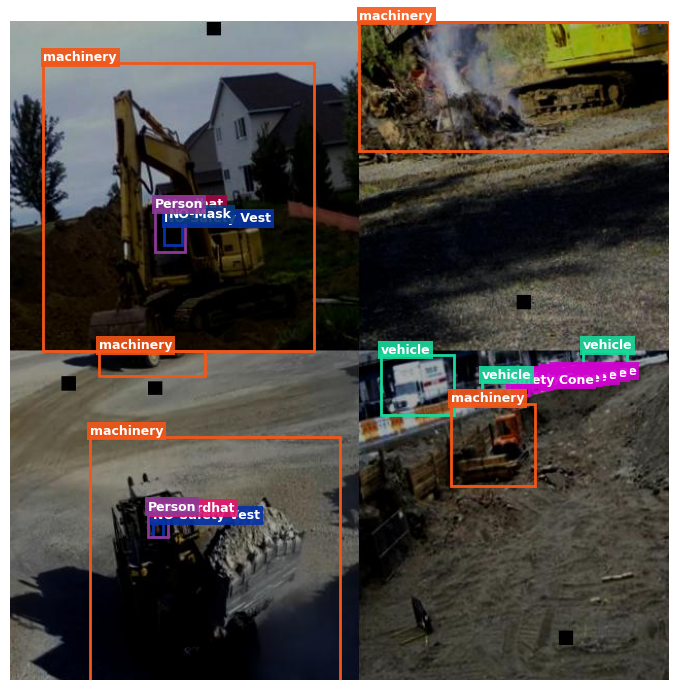

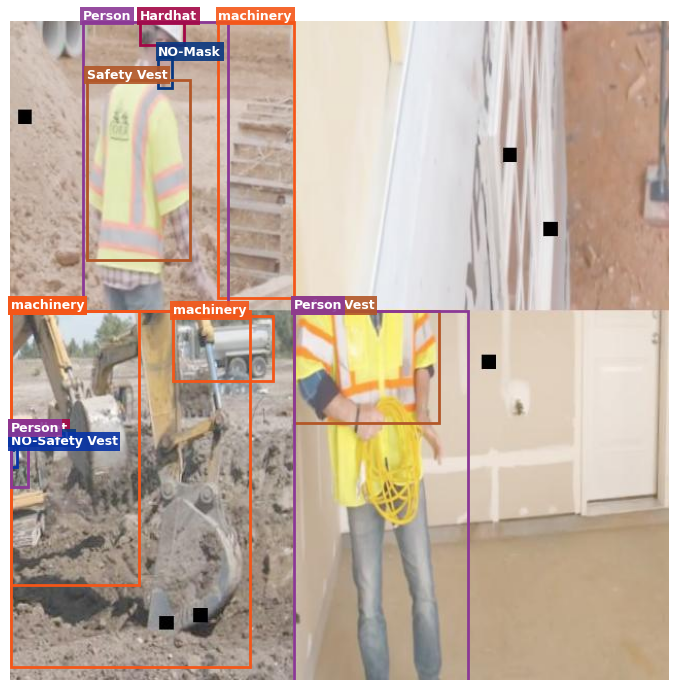

In [ ]:
from matplotlib.patches import Rectangle

# Paleta reproducible de colores (una por clase)
def get_colors(n):
    random.seed(42)
    return {i: (random.random(), random.random(), random.random()) for i in range(n)}

colors = get_colors(len(CLASSES))

def draw_yolo_boxes(img_path: Path, lbl_path: Path, class_names):
    img = np.array(Image.open(img_path).convert('RGB'))
    h, w = img.shape[:2]

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(img)
    ax.axis('off')

    with open(lbl_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cid = int(parts[0])
                xc, yc, bw, bh = map(float, parts[1:5])
                # Desnormalizar
                x = (xc - bw / 2) * w
                y = (yc - bh / 2) * h
                ww = bw * w
                hh = bh * h

                color = colors.get(cid, (1, 0, 0))
                rect = Rectangle(
                    (x, y), ww, hh,
                    fill=False,
                    linewidth=2,
                    edgecolor=color,
                )
                ax.add_patch(rect)

                label = class_names[cid] if 0 <= cid < len(class_names) else f'id{cid}'
                # Estilo de etiqueta tipo YOLO
                ax.text(
                    x,
                    y - 2,
                    label,
                    color='white',
                    fontsize=9,
                    fontweight='bold',
                    bbox=dict(facecolor=color, alpha=0.9, edgecolor='none', pad=2),
                )
    plt.tight_layout()
    plt.show()


# Muestra N imágenes al azar del split 'train'
N = 5
train_imgs = sorted((DATASET_ROOT / 'train' / 'images').glob('*'))
random.shuffle(train_imgs)
for pimg in train_imgs[:N]:
  plbl = DATASET_ROOT / 'train' / 'labels' / (pimg.stem + '.txt')
  draw_yolo_boxes(pimg, plbl, CLASSES)

## 6) Entrenamiento con YOLOv11

Entrenaremos con un modelo ligero (`yolo11n.pt`) para tiempos razonables. Puedes cambiar por `yolo11s.pt`, `yolo11m.pt`, etc.


In [ ]:
# Carga de modelo YOLOv11 (Ultralytics). Cambia el checkpoint si quieres otro tamaño.
# Opciones típicas: yolo11n.pt, yolo11s.pt, yolo11m.pt, yolo11l.pt, yolo11x.pt
model = YOLO('yolo11n.pt')

# Hiperparámetros básicos
EPOCHS = 10
BATCH  = 64
IMGSZ  = 640
RUN_NAME = 'yolo11n_lab3'

results = model.train(data=str(DATA_YAML_PATH),
                      imgsz=IMGSZ,
                      epochs=EPOCHS,
                      batch=BATCH,
                      name=RUN_NAME,
                      device=0 if torch.cuda.is_available() else 'cpu')
print("Entrenamiento finalizado. Resultados en:", Path('runs/detect')/RUN_NAME)


Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_lab3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

* **P (Precision)**: Proporción de predicciones positivas que son correctas. (Alta P ⇒ pocas falsas alarmas)

  $$\text{P}=\frac{\text{TP}}{\text{TP}+\text{FP}}$$

* **R (Recall)**: Proporción de objetos reales correctamente detectados. (Alta R ⇒ pocos objetos perdidos)

  $$\text{R}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$

* **Curva Precision–Recall (PR)**: Gráfica que muestra cómo cambian **Precision** y **Recall** al variar el umbral de confianza del detector. Se construye ordenando predicciones por confianza, acumulando TP/FP y calculando (P, R) en cada punto; resume el compromiso entre menos falsas alarmas y menos objetos perdidos.

* **AP (Average Precision)**: Área bajo la curva PR para una clase y un umbral de IoU fijo. Mide simultáneamente precisión y cobertura para esa clase.

* **mAP\@0.5 (mAP50)**: Promedio de AP sobre todas las clases usando IoU = 0.50 (criterio más permisivo).

* **mAP\@0.5:0.95 (mAP50-95 / COCO mAP)**: Promedio de AP sobre todas las clases y 10 umbrales de IoU: 0.50, 0.55, …, 0.95 (criterio más exigente de localización).


## 7) Evaluación y predicciones en imágenes

Cargamos los pesos `best.pt` y ejecutamos predicciones sobre los datos de test. Mostramos métricas y algunas predicciones.


In [ ]:
best_weights = Path('runs/detect')/RUN_NAME/'weights'/'best.pt'

best_model = YOLO(str(best_weights))

metrics = best_model.val(
    data=str(DATA_YAML_PATH),
    split='test',
    imgsz=IMGSZ,
    conf=0.25,
    iou=0.6,
    plots=True,
    verbose=False
)

# Resumen robusto
def safe_attr(obj, name, default=None):
    return getattr(obj, name, default) if obj is not None else default

mp = safe_attr(getattr(metrics, 'box', None), 'map', None)
mp50 = safe_attr(getattr(metrics, 'box', None), 'map50', None)
mp75 = safe_attr(getattr(metrics, 'box', None), 'map75', None)
precision = safe_attr(getattr(metrics, 'box', None), 'mp', None)
recall    = safe_attr(getattr(metrics, 'box', None), 'mr', None)

print("==== Métricas (test) ====")
if mp is not None:    print(f"mAP@0.5:0.95 : {mp:.4f}")
if mp50 is not None:  print(f"mAP@0.5      : {mp50:.4f}")
if mp75 is not None:  print(f"mAP@0.75     : {mp75:.4f}")
if precision is not None: print(f"Precision (mean): {precision:.4f}")
if recall is not None:    print(f"Recall (mean)   : {recall:.4f}")


Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1691.0±366.1 MB/s, size: 61.9 KB)
val: Scanning /root/.cache/kagglehub/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/versions/3/css-data/test/labels.cache... 82 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 82/82 122.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.9it/s 3.2s
                   all         82        760      0.786      0.593      0.721      0.409
Speed: 4.5ms preprocess, 5.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/runs/detect/val2
==== Métricas (test) ====
mAP@0.5:0.95 : 0.4089
mAP@0.5      : 0.7211
mAP@0.75     : 0.4125
Precisión (mean): 0.7859
Recall (mean)   : 0.5926


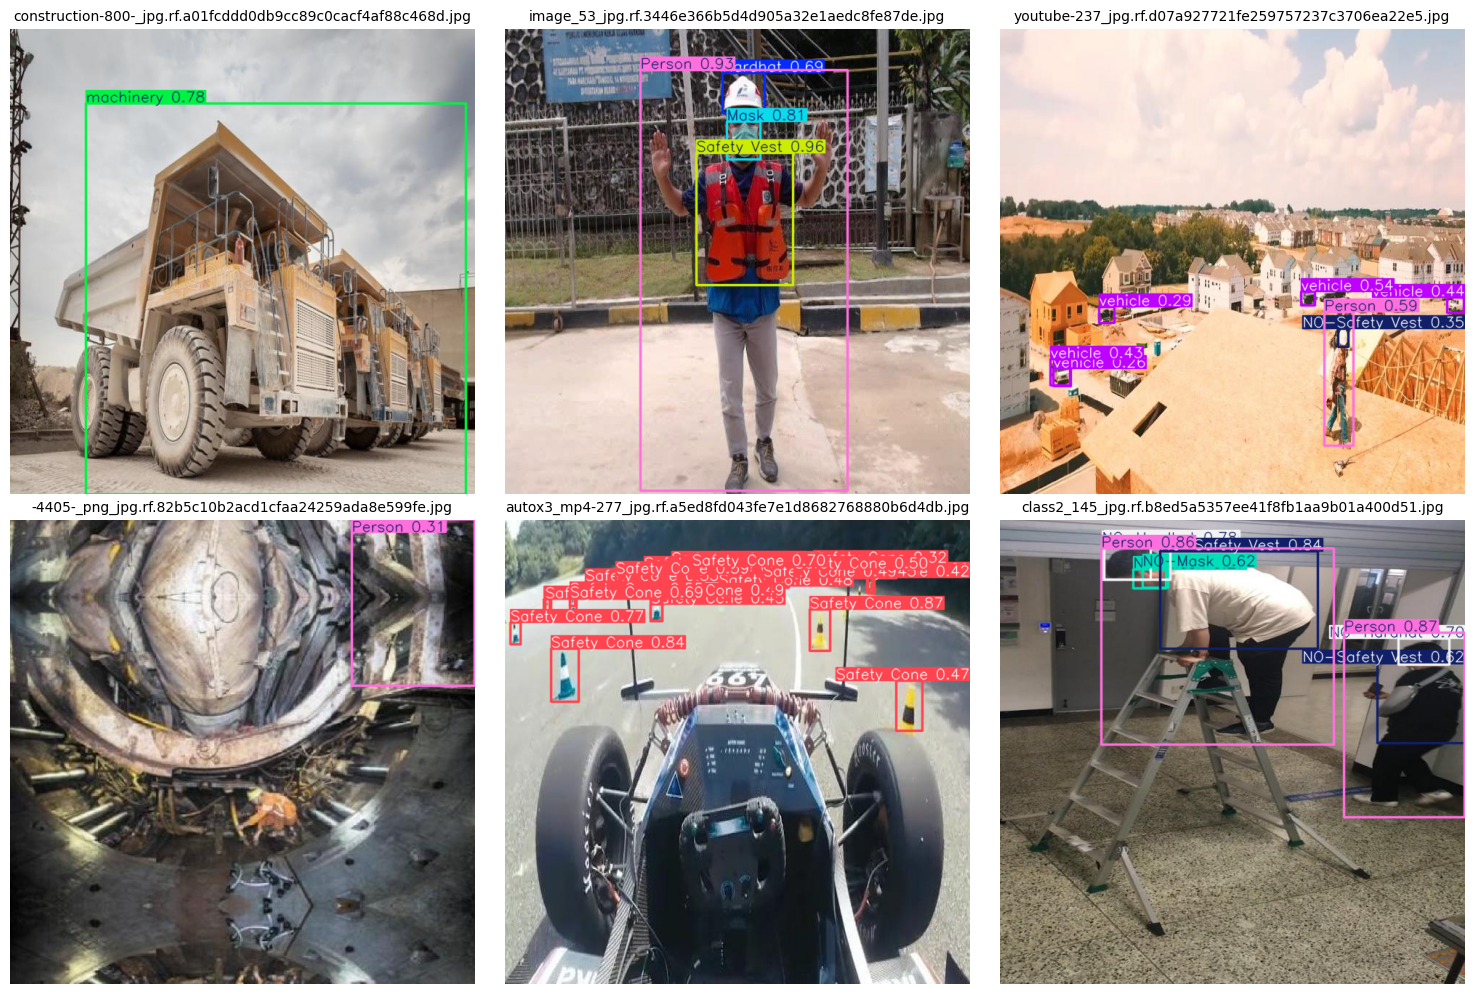

In [ ]:
# Visualizar algunas imágenes de test con inferencia
TEST_DIR = DATASET_ROOT / 'test' / 'images'
test_imgs = []
for ext in ('*.jpg', '*.jpeg', '*.png', '*.bmp'):
    test_imgs.extend(glob.glob(str(TEST_DIR / ext)))
random.shuffle(test_imgs)

N = min(6, len(test_imgs))
cols = 3
rows = int(np.ceil(N / cols))
plt.figure(figsize=(5*cols, 5*rows))
for i, img_path in enumerate(test_imgs[:N]):
    res = best_model(img_path, conf=0.25, verbose=False)[0]
    im_bgr = res.plot()
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(im_rgb)
    ax.set_title(Path(img_path).name, fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 8) Inferencia

Sube una imagen y ejecuta la inferencia.

Saving mineros.jpg to mineros.jpg
→ Inferencia: mineros.jpg


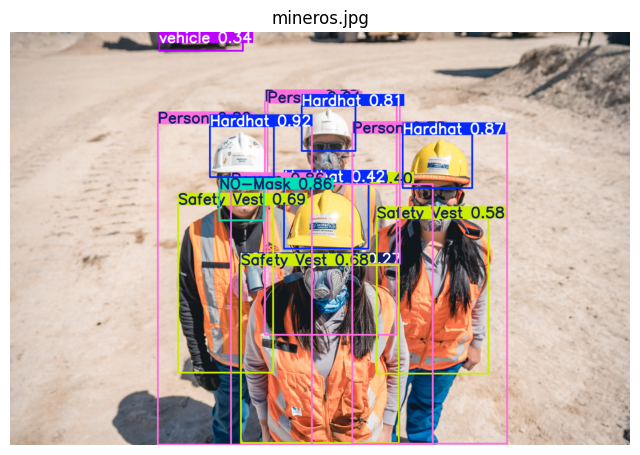

In [ ]:
uploaded = files.upload()  # selecciona 1+ imágenes
if not uploaded:
    print("No subiste archivos.")
else:
    for fname in uploaded.keys():
        print(f"→ Inferencia: {fname}")
        preds = best_model.predict(source=fname, conf=0.25, verbose=False)
        if not preds:
            print("  (sin resultados)")
            continue
        im_bgr = preds[0].plot()          # imagen con cajas (BGR)
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 8))
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.title(Path(fname).name)
        plt.show()

## 9) Inferencia en tiempo real con Webcam


In [ ]:
# @title
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)  # BGR
  return img

def bbox_to_bytes(bbox_array):
  bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  return 'data:image/png;base64,{}'.format(str(b64encode(iobuf.getvalue()), 'utf-8'))

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       try { stream.getVideoTracks()[0].stop(); } catch(e) {}
       if (video) video.remove();
       if (div) div.remove();
       video = null; div = null; stream = null;
       imgElement = null; captureCanvas = null; labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) window.requestAnimationFrame(onAnimationFrame);
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8);
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) return stream;

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      div.style.position = 'relative';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "environment" }});
      div.appendChild(video);

      try {
        const track = stream.getVideoTracks()[0];
        const caps = (track.getCapabilities && track.getCapabilities()) || {};

        // 1) focusMode: continuous -> single-shot -> lo que haya
        if (caps.focusMode && caps.focusMode.length) {
          const mode =
            caps.focusMode.includes('continuous') ? 'continuous' :
            (caps.focusMode.includes('single-shot') ? 'single-shot' : caps.focusMode[0]);
          await track.applyConstraints({ advanced: [{ focusMode: mode }] });
          console.log('focusMode set to:', mode);
        }

        // 2) focusDistance: coloca a la mitad del rango como ejemplo (opcional)
        if (caps.focusDistance && typeof caps.focusDistance.min === 'number' && typeof caps.focusDistance.max === 'number') {
          const mid = (caps.focusDistance.min + caps.focusDistance.max) / 2;
          await track.applyConstraints({ advanced: [{ focusDistance: mid }] });
          console.log('focusDistance set to mid:', mid);
        };
      } catch (e) {
        console.log('Focus constraints not applied:', e);
      }

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.top = '0px';
      imgElement.style.left = '0px';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);
      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var t0 = Date.now();
      stream = await createDom();

      if (label != "") labelElement.innerHTML = label;

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var t1 = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      var t2 = Date.now();

      return {'create': t1 - t0, 'capture': t2 - t1, 'img': result};
    }
  ''')
  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
MODEL_WEIGHTS = best_weights # o 'yolo11n.pt'
CONF_THRES = 0.35
IMG_SIZE = 640
CAP_W, CAP_H = 640, 480

# carga modelo
model = YOLO(MODEL_WEIGHTS)
CLASS_NAMES = model.names  # dict {id: name}

# paleta de colores fija por clase
random.seed(42)
COLORS = {int(k): (int(255*random.random()), int(255*random.random()), int(255*random.random()))
          for k in CLASS_NAMES.keys()}

video_stream()
label_html = 'YOLO: ready'
bbox = ''

try:
  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break

    # 1) Frame desde JS -> OpenCV (BGR, 640x480)
    frame = js_to_image(js_reply["img"])
    if frame is None:
      continue

    # 2) Inferencia YOLO (numpy BGR es válido)
    results = model(frame, imgsz=IMG_SIZE, conf=CONF_THRES, verbose=False)[0]

    # 3) Preparar overlay RGBA transparente
    overlay = np.zeros((CAP_H, CAP_W, 4), dtype=np.uint8)

    # 4) Pintar cajas y etiquetas
    if results.boxes is not None and len(results.boxes) > 0:
      xyxy = results.boxes.xyxy.cpu().numpy().astype(int)
      cls  = results.boxes.cls.cpu().numpy().astype(int)
      conf = results.boxes.conf.cpu().numpy()

      for (x1, y1, x2, y2), c, s in zip(xyxy, cls, conf):
        # clip a los límites
        x1 = max(0, min(CAP_W-1, x1)); y1 = max(0, min(CAP_H-1, y1))
        x2 = max(0, min(CAP_W-1, x2)); y2 = max(0, min(CAP_H-1, y2))
        if x2 <= x1 or y2 <= y1: continue

        name = CLASS_NAMES.get(int(c), str(int(c)))
        color = COLORS.get(int(c), (0, 255, 0))  # BGR

        # caja
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)

        # etiqueta
        label = f"{name} {s:.2f}"
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        x_bg2 = min(x1 + tw + 6, CAP_W-1)
        y_bg2 = min(y1 + th + 6, CAP_H-1)
        cv2.rectangle(overlay, (x1, y1), (x_bg2, y_bg2), color, -1)
        cv2.putText(overlay, label, (x1+3, y1+th+1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255,255), 1, cv2.LINE_AA)

    # 5) Alpha channel: 255 donde haya trazos
    overlay[..., 3] = (overlay[..., :3].max(axis=2) > 0).astype(np.uint8) * 255

    # 6) Enviar overlay al front-end
    bbox = bbox_to_bytes(overlay)

    # 7) Actualizar label con métricas básicas
    label_html = f"YOLO: {len(results.boxes) if results.boxes is not None else 0} objs | create:{js_reply.get('create',0)}ms capture:{js_reply.get('capture',0)}ms"

except KeyboardInterrupt:
  pass

<IPython.core.display.Javascript object>